In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import product


In [17]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 100000

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 360.0 * \
        np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * \
        np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = np.array(
        [objective_function(c) for c in current_population_solutions])

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - \
            current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(
            population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros(
            (number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros(
            (number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(
                axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(
                axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(
            number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + \
            children_population_sigmas * \
            np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = np.array(
            [objective_function(c) for c in children_population_solutions])
        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack(
            [current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack(
            [current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack(
            [current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[
            I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(
        ), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0 and False:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (
                t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas


In [93]:
def get_points(x_start, y_start, components, alphas, debug = False):
    x = [x_start]
    y = [y_start]
    alphas_r = np.radians(alphas)
    last_x, last_y = x_start, y_start
    for (c, a) in zip(components, alphas_r):
        x_curr = last_x + c * np.cos(a)
        if debug:
            print("component, alpha: ", c, a)
            print("sin a: ", np.sin(a))
            print("last y, new y: ",last_y, last_y + c * np.sin(a))
        y_curr = last_y + c * np.sin(a)
        last_x, last_y = x_curr, y_curr
        x.append(x_curr)
        y.append(y_curr)
    if debug:
        print("x: ", x)
        print("y: ", y)
    return x, y


def plot_robot(x, y, x_dest, y_dest):
    plt.figure()
    plt.plot(x_dest, y_dest, 'bo')
    plt.plot(x, y, '-bo',  c='black',
             markerfacecolor='red', markeredgecolor='k')


In [94]:
def onSegment(p, q, r):
    if ((q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and
            (q[1] <= max(p[1], r[1])) and (q.y >= min(p[1], r[1]))):
        return True
    return False


def orientation(p, q, r):
    val = (float(q[1] - p[1]) * (r[0] - q[0])) - \
        (float(q[0] - p[0]) * (r[1] - q[1]))
    if (val > 0):
        return 1
    elif (val < 0):
        return 2
    else:
        return 0


def intersects(a, b):
    p1, q1 = a[0], a[1]
    p2, q2 = b[1], b[0]
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if ((o1 != o2) and (o3 != o4)):
        return True

    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return True

    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return True

    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return True

    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return True

    return False


In [110]:
def get_objective_f(x_start, y_start, x_dest, y_dest, components, obstacles):
    def obj_f(alphas):
        score = 0
        x, y = get_points(x_start, y_start, components, alphas)
        x_last = x[-1]
        y_last = y[-1]
        segments = [[[x[i], y[i]], [x[i+1], y[i+1]]] for i in range(len(x)-1)]
        if sum([intersects(t[0], t[1]) for t in list(product(segments, obstacles))]):
            score -= 1000
        score = score - (x_last - x_dest)**2 - (y_last - y_dest)**2
        return score
    return obj_f


In [111]:
def solve(components, population_size, iterations, obstacles_num):
    x_start = 0
    y_start = 0
    r = np.sum(components)
    obstacles = []
    theta = np.radians(np.random.randint(360))
    x_dest = r*np.cos(theta) * 0.9
    y_dest = r*np.sin(theta) * 0.9

    obj_f = get_objective_f(x_start, y_start, x_dest,
                            y_dest, components, obstacles)
    best_solution_objective_value, best_solution, \
        log_objective_values, log_best_solutions, log_best_sigmas = es(
            obj_f, len(components), population_size, iterations, 2*population_size, 2, 50.0, 1/np.sqrt(2*len(components)), 1/np.sqrt(2*np.sqrt(len(components))), 10)

    def init():
        line.set_data([], [])
        iteration_text.set_text('')
        obj_f_value_text.set_text('')
        return line, iteration_text, obj_f_value_text

    def animate(i):
        x, y = get_points(x_start, y_start, components, log_best_solutions[i])
        line.set_data(x, y)
        iteration_text.set_text('iteration = {}'.format(i))
        obj_f_value_text.set_text(
            'obj_f = ' + '{:.2f}'.format(-obj_f(log_best_solutions[i])))
        return line, iteration_text, obj_f_value_text

    # Plotting robotic arm
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(xlim=(-r*1.2, r*1.2),
                  ylim=(-r*1.2, r*1.2))

    line, = ax.plot([], [], '-bo',  c='black',
                    markerfacecolor='red', markeredgecolor='k', lw=3)
    iteration_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    obj_f_value_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
    start_p = ax.plot(x_start, y_start, 'bo')
    dest_p = ax.plot(x_dest, y_dest, 'go')

    anim = FuncAnimation(fig, animate, init_func=init,
                         frames=iterations, interval=85, blit=True)
    anim.save('no_obstacles.gif', writer='imagemagick')


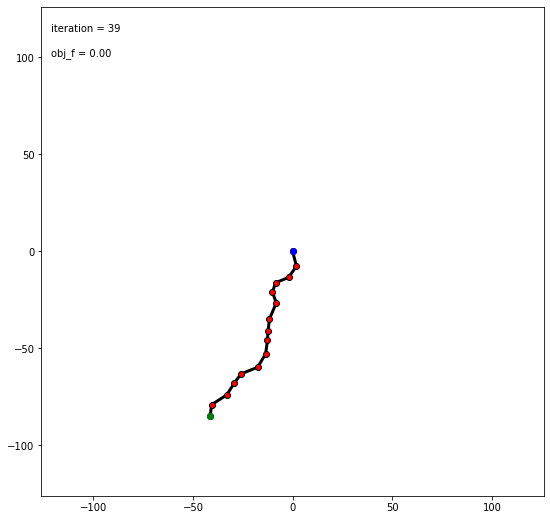

In [112]:
comps = np.random.randint(low=5, high=10, size=15)
solve(comps, 40, 40, 4)


In [124]:
def solve_obstacles(components, population_size, iterations, obstacles=np.array([[[60, 0], [60, 60]]]), gif_name = 'easy_obstacle.gif'):
    x_start = 0
    y_start = 0
    r = 100
    theta = np.radians(np.random.randint(360))
    x_dest = 90
    y_dest = 90

    obj_f = get_objective_f(x_start, y_start, x_dest,
                            y_dest, components, obstacles)
    best_solution_objective_value, best_solution, \
        log_objective_values, log_best_solutions, log_best_sigmas = es(
            obj_f, len(components), population_size, iterations, 2*population_size, 2, 50.0, 1/np.sqrt(2*len(components)), 1/np.sqrt(2*np.sqrt(len(components))), 10)

    x, y = get_points(x_start, y_start, components, log_best_solutions[-1], False)
    segments = [[[x[i], y[i]], [x[i+1], y[i+1]]] for i in range(len(x)-1)]

    def init():
        line.set_data([], [])
        iteration_text.set_text('')
        obj_f_value_text.set_text('')
        return line, iteration_text, obj_f_value_text

    def animate(i):
        x, y = get_points(x_start, y_start, components, log_best_solutions[i])
        line.set_data(x, y)
        iteration_text.set_text('iteration = {}'.format(i))
        obj_f_value_text.set_text(
            'obj_f = ' + '{:.2f}'.format(-obj_f(log_best_solutions[i])))
        return line, iteration_text, obj_f_value_text

    # Plotting robotic arm
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(xlim=(-r*0.2, r*1.2),
                  ylim=(-r*0.2, r*1.2))
    line, = ax.plot([], [], '-bo',  c='black',
                    markerfacecolor='red', markeredgecolor='k', lw=3)

    for i in range(len(obstacles)):
        ax.plot(obstacles[i][:, 0], obstacles[i][:, 1], '-m')
    # obstacles_p, = ax.plot(
    #     np.hstack(obstacles[:, :, 0]), np.hstack(obstacles[:, :, 1]), '-m')
    iteration_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    obj_f_value_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
    start_p = ax.plot(x_start, y_start, 'bo')
    dest_p = ax.plot(x_dest, y_dest, 'go')

    anim = FuncAnimation(fig, animate, init_func=init,
                         frames=iterations, interval=85, blit=True)
    anim.save(gif_name, writer='imagemagick')


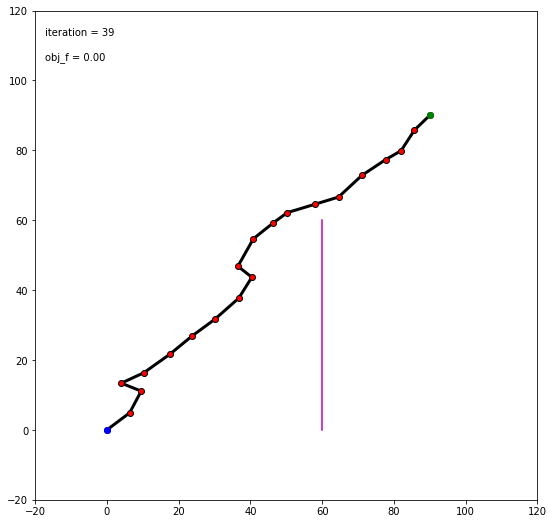

In [125]:
comps = np.random.randint(low=5, high=10, size=20)
solve_obstacles(comps, 40, 40)

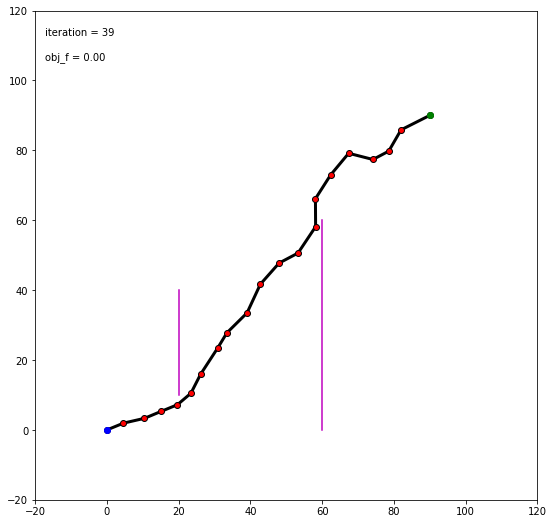

In [126]:
comps = np.random.randint(low=5, high=10, size=20)
two_obstacles = np.array([[[60, 0], [60, 60]], [[20, 10], [20, 40]]])
solve_obstacles(comps, 40, 40, two_obstacles, 'two_obstacles.gif')


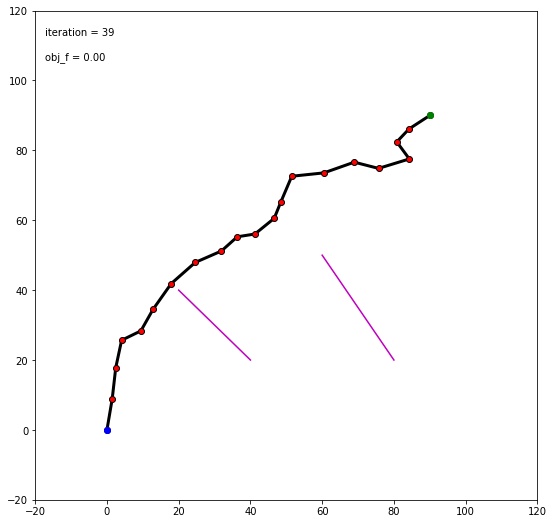

In [128]:
comps = np.random.randint(low=5, high=10, size=20)
two_obstacles = np.array([[[60, 50],[80, 20]],[[40, 20], [20, 40]]])
solve_obstacles(comps, 40, 40, two_obstacles, 'two_obstacles_diagonal.gif')


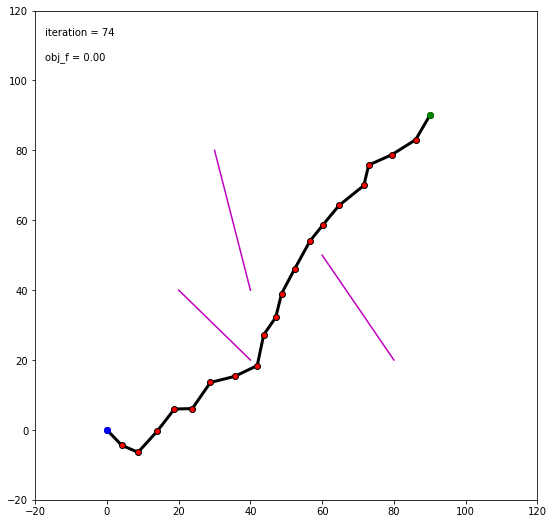

In [134]:
comps = np.random.randint(low=5, high=10, size=20)
three_obstacles = np.array([[[60, 50], [80, 20]], [[40, 20], [20, 40]], [[30, 80], [40, 40]]])
solve_obstacles(comps, 40, 75, three_obstacles, 'three_diagonal.gif')
